# Nonlinear Pendulum

This notebook details how the equation of motion for a pendulum consisting of a mass suspended from a massless, inextensible rod of length $l$ can be solved using traditional numerical methods and deep learning.

In [173]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
import torch
from torch import nn, autograd

plt.style.use("dark_background")

The equation of motion of the mass can be derived using Newtonian mechanics.

\begin{gather*}
    \sum F_r = T - mg\cos\theta = ml\dot{\theta}^2 \\
    \sum F_\theta = -mg\sin\theta - bl\dot{\theta} = ml\ddot{\theta} \\
    \ddot{\theta} = -\frac{g}{l} \sin\theta - \frac{b}{m} \dot{\theta}
\end{gather*}

The equation of motion can be solved for $\theta(t)$ given the physical constants in the equation of motion, $\theta(0) = \theta_0$ and $\dot{\theta}(0) = \omega_0$. 

Define physical constants and initial conditions.

In [174]:
g = 9.8
l = 1
m = 1
b = 0.6

theta_0 = np.pi/6
omega_0 = 0

## Method 1: Runge-Kutta Method

The equation of motion can be transformed into a first order initial value problem (i.e. $y'(t) = f(t, y(t))$) which can be solved numerically using Runge-Kutta methods.

$$\frac{d}{dt} \begin{bmatrix} \theta \\ \omega \end{bmatrix} = \begin{bmatrix} \omega \\ -\frac{g}{l} \sin\theta - \frac{b}{m} \omega \end{bmatrix}$$

with initial conditions $\theta(0) = \theta_0$ and $\omega(0) = \omega_0$

Define $f(t, y(t)) = y'(t)$

In [175]:
def f(t, y):
    return np.array([y[1], - g / l * np.sin(y[0]) - b / m * y[1]])

Numerically solve using Scipy.

In [176]:
t_end = 10
h = 0.02

y0 = np.array([theta_0, omega_0])

num_solution = solve_ivp(f, (0, t_end), y0, max_step=h)

Plot the results.

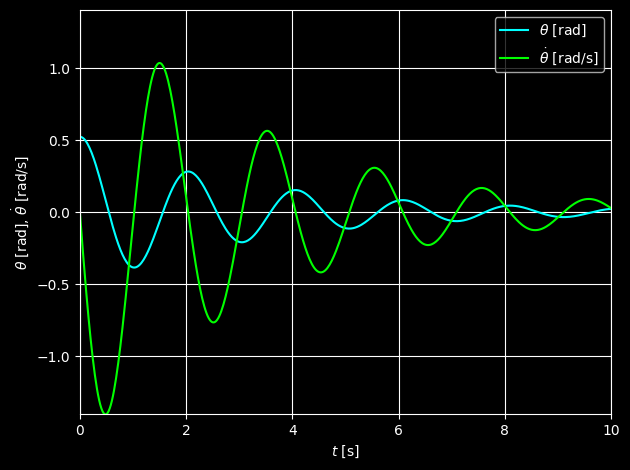

In [177]:
fig, ax = plt.subplots()

ax.plot(num_solution.t, num_solution.y[0], color="cyan")
ax.plot(num_solution.t, num_solution.y[1], color="lime")

ax.set_xlim([num_solution.t[0], num_solution.t[-1]])
ax.set_ylim([-np.max(np.abs(num_solution.y)), np.max(np.abs(num_solution.y))])
ax.set_xlabel(r"$t$ [s]")
ax.set_ylabel(r"$\theta$ [rad], $\dot{\theta}$ [rad/s]")
ax.legend([r"$\theta$ [rad]", r"$\dot{\theta}$ [rad/s]"], loc="upper right")
ax.grid()

fig.tight_layout()

fig.savefig("output/numerical_plot.png", dpi=300)
plt.show()

## Method 2: Physics Informed Neural Networks

The universal approximation theorem states that a neural network can be trained to approximate the solution to the equation of motion for given initial conditions and parameters.

$$NN(t; \theta) \approx \theta(t)$$

We use the same values of the physical constants and initial conditions as in Method 1 and train the neural network over the domain $t \in [0, 10]$.

The PINN is trained with the following loss function, which consists of a boundary loss term (which enforces the initial conditions), and a physics loss term (which enforces the equation of motion at a set of uniformly spaced collocation points $\{t_i\} \subset [0, 10]$).

$$L(\theta) = \left(NN(0; \theta) - \theta_0\right)^2 + \lambda_1 \left(\frac{dNN}{dt}(0; \theta) - \omega_0\right)^2 + \frac{\lambda_2}{N} \sum_{i = 1}^N \left(\frac{d^2NN}{dt}(t_i; \theta) + \frac{b}{m} \frac{dNN}{dt}(t_i; \theta)+ \frac{g}{l} \sin\left(NN(t_i; \theta)\right) \right)^2$$

This loss function was inspired by the [ETH Zurich Deep Learning in Scientific Computing course (2023)](https://camlab.ethz.ch/teaching/deep-learning-in-scientific-computing-2023.html).

Optimisation

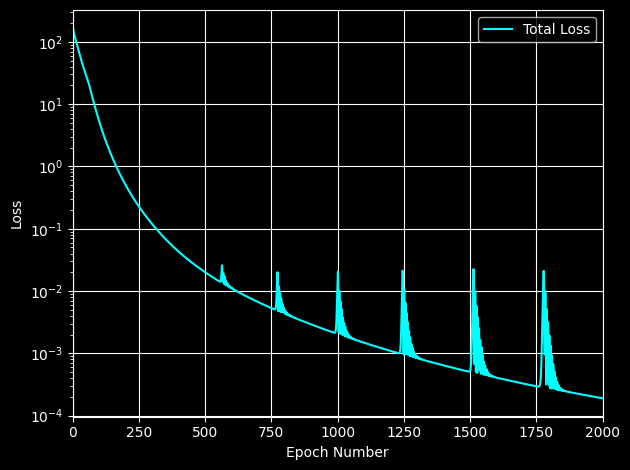

In [178]:
class PINN(nn.Module):
    def __init__(self, layers, activation_function):
        super().__init__()
        self.model = nn.Sequential()
        for i in range(1, len(layers)):
            self.model.append(nn.Linear(layers[i-1], layers[i]))
            if i != len(layers) - 1:
                self.model.append(activation_function)
    
    def forward(self, x):
        return self.model(x)

torch.manual_seed(88)
pinn = PINN([1,20,20,1], nn.Tanh())

t_initial = torch.tensor(0.0).view(-1, 1).requires_grad_(True)

step_physics = 0.25
t_physics = torch.arange(0, t_end + step_physics, step_physics).view(-1, 1).requires_grad_(True)

t_test = torch.arange(0, t_end + h, h).view(-1, 1).requires_grad_(True)

def test_func(t):
    return 2*t + 1

optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-2)
epochs = 2000

losses = np.empty(epochs)
solutions = [pinn(t_test).detach().numpy()]

for epoch in range(1, epochs + 1):
    optimiser.zero_grad()

    lambda_1, lambda_2 = 1, 1

    sol = pinn(t_physics)
    loss = torch.mean((torch.squeeze(sol) - torch.squeeze(test_func(t_physics)))**2)
    losses[epoch - 1] = loss
    
    if epoch % 10 == 0: solutions.append(pinn(t_test).detach().numpy())
    
    loss.backward()
    optimiser.step()

fig, ax = plt.subplots()

ax.plot(np.arange(1, epochs + 1), losses, color="cyan")
ax.set_yscale('log')
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss")
ax.set_xlim([0, epochs])
ax.legend(["Total Loss"])
ax.grid()

fig.tight_layout()

fig.savefig("output/loss_plot.png", dpi=300)
plt.show()

Plot the PINN computed solution

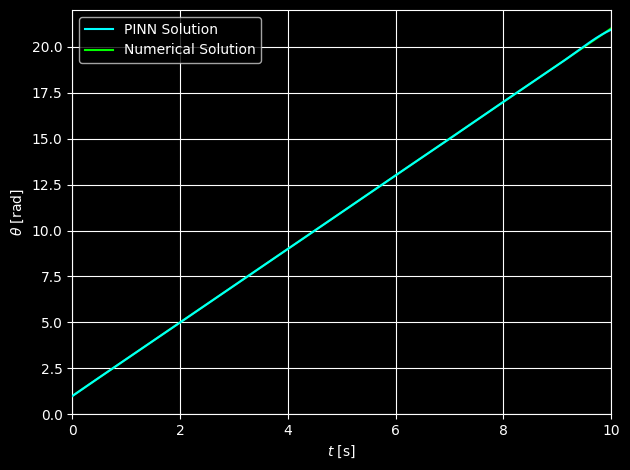

In [179]:
pinn_solution = pinn(t_test)

fig, ax = plt.subplots()

ax.plot(t_test.detach().numpy(), pinn_solution.detach().numpy(), color = "cyan", zorder=3)
ax.plot(t_test.detach().numpy(), test_func(t_test.detach().numpy()), color = "lime")
ax.legend(["PINN Solution", "Numerical Solution"])
ax.set_xlabel(r"$t$ [s]")
ax.set_ylabel(r"$\theta$ [rad]")
ax.set_xlim([0, t_end])
ax.grid()

plt.tight_layout()

fig.savefig("output/pinn_plot.png", dpi=300)
plt.show()

Animate the training process.

In [180]:
fig, ax = plt.subplots()

nn_curve, = ax.plot(t_test.detach().numpy(), solutions[0], color = "cyan", zorder=3)
func_curve, = ax.plot(t_test.detach().numpy(), test_func(t_test.detach().numpy()), color = "lime")

ax.set_xlim([0, t_end])
ax.set_ylim([0, 25])
ax.set_title("Epoch = 0")
ax.grid()
ax.legend(["NN", "Function"])

def animate(i):
    nn_curve.set_data(t_test.detach().numpy(), solutions[i])
    ax.set_title(f"Epoch = {i*10}")

anim = animation.FuncAnimation(fig, animate, frames=len(solutions), interval=20)
anim.save("output/training.mp4", dpi=300, writer=animation.FFMpegWriter(fps=50))
plt.close()

Animate the results.

In [181]:
fig = plt.figure(figsize = (7,7))

ax_pendulum = plt.subplot(2, 2, 1, aspect='equal')
ax_pendulum.set_xlim([-1.2*l, 1.2*l])
ax_pendulum.set_ylim([-1.8*l, 0.6*l])
ax_pendulum.set_xticks([])
ax_pendulum.set_yticks([])

mass_x = np.sin(num_solution.y[0, :])
mass_y = -np.cos(num_solution.y[0, :])
rod, = ax_pendulum.plot([0, mass_x[0]], [0, mass_y[0]], color="cyan")
mass, = ax_pendulum.plot(mass_x[0], mass_y[0], "o", color="cyan")

ax_phase = plt.subplot(2, 2, 2)
ax_phase.set_xlim([-np.max(np.abs(num_solution.y[0, :])), np.max(np.abs(num_solution.y[0, :]))])
ax_phase.set_ylim([-np.max(np.abs(num_solution.y[1, :])), np.max(np.abs(num_solution.y[1, :]))])
ax_phase.set_xlabel(r"$\theta$ [rad]")
ax_phase.set_ylabel(r"$\dot{\theta}$ [rad/s]")
ax_phase.grid()

phase_curve, = ax_phase.plot(num_solution.y[0, 0], num_solution.y[1, 0], color="cyan")
current_phase, = ax_phase.plot(num_solution.y[0, 0], num_solution.y[1, 0], marker="o", color="cyan")

ax_solution = plt.subplot(2, 2, (3, 4))
ax_solution.set_xlim([num_solution.t[0], num_solution.t[-1]])
ax_solution.set_ylim([-np.max(np.abs(num_solution.y)), np.max(np.abs(num_solution.y))])
ax_solution.set_xlabel(r"$t$ [s]")
ax_solution.set_ylabel(r"$\theta$ [rad], $\dot{\theta}$ [rad/s]")
ax_solution.grid()

theta_curve, = ax_solution.plot(num_solution.t[0], num_solution.y[0, 0], color="cyan")
theta_dot_curve, = ax_solution.plot(num_solution.t[0], num_solution.y[1, 0], color="cyan", linestyle="dashed")
current_theta, = ax_solution.plot(num_solution.t[0], num_solution.y[0, 0], marker="o", color="cyan")
current_theta_dot, = ax_solution.plot(num_solution.t[0], num_solution.y[1, 0], marker="o", color="cyan")
ax_solution.legend([theta_curve, theta_dot_curve], [r"$\theta$ [rad]", r"$\dot{\theta}$ [rad/s]"], loc="upper right")

plt.tight_layout(pad=1.35)

def animate(i):
    rod.set_data([0, mass_x[i]], [0, mass_y[i]])
    mass.set_data(mass_x[i:i+1], mass_y[i:i+1])

    phase_curve.set_data(num_solution.y[0, :i+1], num_solution.y[1, :i+1])
    current_phase.set_data(num_solution.y[0, i:i+1], num_solution.y[1, i:i+1])

    theta_curve.set_data(num_solution.t[:i+1], num_solution.y[0, :i+1])
    theta_dot_curve.set_data(num_solution.t[:i+1], num_solution.y[1, :i+1])
    current_theta.set_data(num_solution.t[i:i+1], num_solution.y[0, i:i+1])
    current_theta_dot.set_data(num_solution.t[i:i+1], num_solution.y[1, i:i+1])

# anim = animation.FuncAnimation(fig, animate, frames=len(num_solution.t), interval=h*1000)
# anim.save("output/numerical_results.mp4", dpi=300, writer=animation.FFMpegWriter(fps=50))
plt.close()